# Inverse Fast Fourier Transform Indicator

The goal of this program is to design a zero-lag moving average indicator. An inverse fast fourier transform is used with signal padding and a rolling window. The result is a smoothed moving average with lower lag than any other moving average calculation. 

### Import libraries

In [2]:
import os 
import sys
import time
import datetime
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

### Download Stock Data

Download data from Yahoo Finance. Put data into a pandas datafame.

In [48]:
# Define the stock ticker symbol
ticker_symbol = 'NVDA'

# Download stock data
stock_data = yf.download(ticker_symbol, start='2024-02-01', end='2024-07-01')

stock_data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-02-01,188.500000,189.880005,184.279999,188.860001,188.860001,91843300
2024-02-02,185.039993,188.690002,182.000000,187.910004,187.910004,110505100
2024-02-05,184.259995,184.679993,175.009995,181.059998,181.059998,134294400
2024-02-06,177.210007,186.490005,177.110001,185.100006,185.100006,122676000
2024-02-07,188.179993,189.789993,182.679993,187.580002,187.580002,111535200
...,...,...,...,...,...,...
2024-06-24,184.970001,188.800003,182.550003,182.580002,182.580002,61992100
2024-06-25,184.399994,187.970001,182.009995,187.350006,187.350006,63678300
2024-06-26,186.539993,197.759995,186.360001,196.369995,196.369995,95737100


### IFFT Indicator calculation

Signal padding reduces extreme values at the tails.

In [49]:
# IFFT Indicator with Padding
def ifft_indicator(prices, threshold):
    n = len(prices)
    
    # Pad the prices with reflection at both ends
    padding_size = int(n * 0.5)  # 10% of the size for padding
    padded_prices = np.pad(prices, (padding_size, padding_size), mode='reflect')

    fft_transformed = np.fft.fft(padded_prices)
    fft_filtered = np.zeros_like(fft_transformed)

    retain_length = int(threshold * len(padded_prices))
    fft_filtered[:retain_length] = fft_transformed[:retain_length]
    fft_filtered[-retain_length:] = fft_transformed[-retain_length:]

    ifft_transformed = np.fft.ifft(fft_filtered).real

    # Remove padding
    ifft_transformed = ifft_transformed[padding_size:-padding_size]

    return ifft_transformed

In [98]:
# Calculate IFFT
n = len(stock_data)
window_size = min(20, n)

stock_data['IFFT Window'] = np.nan

for i in range(len(stock_data) - window_size):
        
    window_data = stock_data[i: i+window_size]

    window_closing_prices = window_data['Close'].values

    window_ifft_result = ifft_indicator(window_closing_prices, threshold=0.07)

    stock_data['IFFT Window'].iloc[i+window_size] = window_ifft_result[-1]

# Add IFFT result to the DataFrame
stock_data['IFFT'] = ifft_result

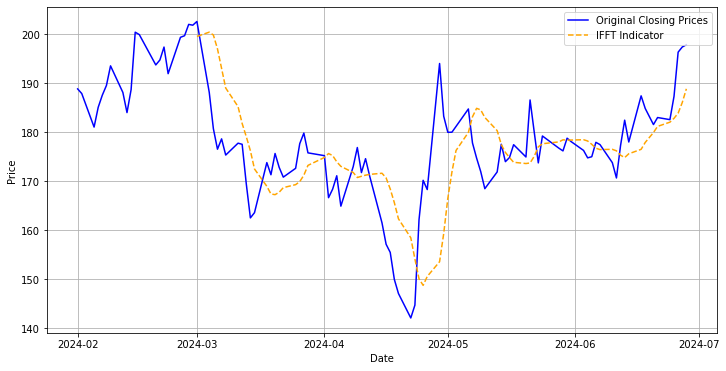

In [99]:
# Plot results
plt.figure(figsize=(12, 6))
plt.plot(stock_data.index, stock_data['Close'], label='Original Closing Prices', color='blue')
plt.plot(stock_data.index, stock_data['IFFT Window'], label='IFFT Indicator', color='orange', linestyle='--')

plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()